# Convolutional Neural Networks: MNIST classification with Keras

This is an annotated version of Keras's [example MNIST CNN code](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py).

The MNIST classification task is a classic machine learning benchmark. The data includes 70,000 handwritten grayscale digits, and the task is to identify them. The digits run from 0 to 9, so this is a multiclass classification problem. There are 10 possible classes, one for each digit.

The MNIST classification task is sort of like a "hello world" for computer vision, so a solution can be implemented quickly with an off-the-shelf machine learning library.

Since convolutional neural networks have thus far proven to be the best at computer vision tasks, we'll use the Keras library to implement a convolutional neural net as our solution. Keras provides a well-designed and readable API on top of both Theano and TensorFlow fast backends, so we'll be done in a surprisingly short amount of steps!

Because MNIST is such a common task, the dataset is included with many machine learning libraries. With Keras, you can load the dataset with just a couple of lines:

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

n_train, n_test, height, width

Using Theano backend.


(60000, 10000, 28, 28)

We have 60,000 28x28 training grayscale images and 10,000 28x28 test grayscale images. Let's visualize some of them.

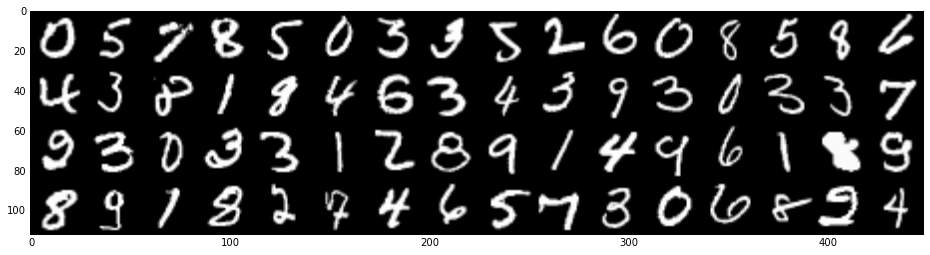

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

samples = np.concatenate([np.concatenate([X_train[i].reshape(28,28) for i in [int(random.random() * len(X_train)) for i in range(16)]], axis=1) for i in range(4)], axis=0)
plt.figure(figsize=(16,4))
plt.imshow(samples, cmap='gray')

Some preprocessing steps are required to get the data into the proper form for the network. The training and test data need to be shaped as (`n`, `w`, `h`, `c`) where `n` is the number of samples, `w` and `h` are the spatial dimensions (width and height) of the samples, and `c` is the number of channels (1 for our grayscale MNIST images, 3 for RGB images). The labels need to be converted into one-hot vectors, which are `nc`-element arrays (`nc` is the number of classes) which are 0 for all classes except 1 for the class the label is assigned to.

In [3]:
from keras.utils.np_utils import to_categorical

# we have to preprocess the data into the right shape
X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

# normalize from [0, 255] to [0, 1]
X_train /= 255
X_test /= 255

# numbers 0-9, so ten classes
n_classes = 10

# convert integer labels into one-hot vectors
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

Keras makes it very easy to define a neural network. We first instantiate a sequential Keras model, meaning the components of the model come one after the other - e.g. layer by layer.

In [4]:
from keras.models import Sequential
model = Sequential()

The general architecture of a convolutional neural network is:

- convolution layers, followed by pooling layers
- fully-connected layers
- a final fully-connected softmax layer

We'll follow this same basic structure and interweave some other components, such as [dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks), to improve performance.

To begin, we start with our convolution layers. We first need to specify some architectural hyperparemeters:

- _How many filters do we want for our convolution layers?_ Like most hyperparameters, this is chosen through a mix of intuition and tuning. A rough rule of thumb is: the more complex the task, the more filters. (Note that we don't need to have the same number of filters for each convolution layer, but we are doing so here for convenience.)
- _What size should our convolution filters be?_ We don't want filters to be too large or the resulting matrix might not be very meaningful. For instance, a useless filter size in this task would be a 28x28 filter since it covers the whole image. We also don't want filters to be too small for a similar reason, e.g. a 1x1 filter just returns each pixel.
- _What size should our pooling window be?_ Again, we don't want pooling windows to be too large or we'll be throwing away information. However, for larger images, a larger pooling window might be appropriate (same goes for convolution filters).

In [5]:
# number of convolutional filters
n_filters = 32

# convolution filter size
# i.e. we will use a n_conv x n_conv filter
n_conv = 3

# pooling window size
# i.e. we will use a n_pool x n_pool pooling window
n_pool = 2

Now we can begin adding our convolution and pooling layers.

We're using only two convolutiona layers because this is a relatively simple task. Generally for more complex tasks you may want more convolution layers to extract higher and higher level features.

For our convolution activation functions we use ReLU, which is common and effective. The particular pooling layer we're using is a max pooling layer.

In [6]:
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D

model.add(Convolution2D(
        n_filters, 
        kernel_size=(n_conv, n_conv),
        # we have a 28x28 single channel (grayscale) image
        # so the input shape should be (28, 28, 1)
        input_shape=(height, width, 1)
))
model.add(Activation('relu'))

model.add(Convolution2D(n_filters, kernel_size=(n_conv, n_conv)))
model.add(Activation('relu'))

# then we apply pooling to summarize the features
# extracted thus far
model.add(MaxPooling2D(pool_size=(n_pool, n_pool)))

Then we can add dropout and our fully-connected ("Dense") and output (softmax) layers.

In [7]:
from keras.layers import Dropout, Flatten, Dense

model.add(Dropout(0.25))

# flatten the data for the 1D layers
model.add(Flatten())

# Dense(n_outputs)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# the softmax output layer gives us a probablity for each class
model.add(Dense(n_classes))
model.add(Activation('softmax'))

We tell Keras to compile the model using whatever backend we have configured (Theano or TensorFlow). At this stage we specify the loss function we want to optimize. Here we're using categorical cross-entropy, which is the standard loss function for multiclass classification.

We also specify the particular optimization method we want to use. Here we're using Adam, which adapts the learning rate based on how training is going and improves the training process.

In [8]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Now that the model is defined and compiled, we can begin training and fit the model to our training data.

Here we're training for only 10 epochs. This is plenty for this task, but for more difficult tasks, more epochs may be necessary.

Training will take quite a while if you are running this on a CPU. Generally with neural networks, and especially with convolutional neural networks, you want to train on a GPU for much, much faster training times. Again, this dataset is relatively small so it won't take a terrible amount of time, but more than you might want to sit around and wait for.

In [9]:
# how many examples to look at during each update step
batch_size = 128

# how many times to run through the full set of examples
n_epochs = 10

# the training may be slow depending on your computer
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(X_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 79s - loss: 0.2837 - acc: 0.9136 - val_loss: 0.0586 - val_acc: 0.9803
Epoch 2/10
60000/60000 [==============================] - 79s - loss: 0.0970 - acc: 0.9706 - val_loss: 0.0396 - val_acc: 0.9869
Epoch 3/10
60000/60000 [==============================] - 80s - loss: 0.0758 - acc: 0.9778 - val_loss: 0.0391 - val_acc: 0.9870
Epoch 4/10
60000/60000 [==============================] - 79s - loss: 0.0619 - acc: 0.9814 - val_loss: 0.0343 - val_acc: 0.9892
Epoch 5/10
60000/60000 [==============================] - 79s - loss: 0.0530 - acc: 0.9837 - val_loss: 0.0353 - val_acc: 0.9878
Epoch 6/10
60000/60000 [==============================] - 80s - loss: 0.0487 - acc: 0.9848 - val_loss: 0.0303 - val_acc: 0.9898
Epoch 7/10
60000/60000 [==============================] - 80s - loss: 0.0425 - acc: 0.9868 - val_loss: 0.0310 - val_acc: 0.9897
Epoch 8/10
60000/60000 [==============================

Now we can evaluate the model on the test data to get a sense of how we did.

In [10]:
# how'd we do?
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print('loss:', loss)
print('accuracy:', accuracy)

('loss:', 0.029475225206009783)
('accuracy:', 0.99150000000000005)


99.06% accuracy on our test set. Not too bad for 10 minutes of training. Believe it or not, this would have been the best performing network for MNIST until around 2003. [As of today](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) the best performing MNIST classifier achieves a 99.79% accuracy. We'll eventually need more innovations to get up to that.

If you want to make a prediction on a single sample, the following code will reshape it into a batch of size 1, output the probability of each classes, and find the index of the maximum probability.

In [23]:
x_sample = X_test[0].reshape(1,28,28,1)
y_prob = model.predict(x_sample)[0]
y_pred = y_prob.argmax()
y_actual = y_test[0].argmax()

print("probabilities: ", y_prob)
print("predicted = %d, actual = %d" % (y_pred, y_actual))

('probabilities: ', array([  2.54888879e-15,   6.91964472e-11,   2.06181427e-09,
         2.51610981e-08,   2.25821830e-13,   5.61656299e-14,
         4.43780486e-19,   9.99999940e-01,   1.14250384e-12,
         3.20635762e-09], dtype=float32))
predicted = 7, actual = 7
